In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchviz import make_dot
from torchview import draw_graph

from pathlib import Path
from tqdm import tqdm
from graphviz import Source
from itertools import islice

from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import nice_rc, corner, mark_point, coverage_plot

from train import NPEWithEmbedding
import h5py

%load_ext autoreload
%autoreload 2

In [2]:
# plt.rcParams.update(nice_rc(latex=False))

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [3]:
def rescale_output(input, forward=False):

    device = str(input.device)
    input = input.clone().detach().cuda()

    scale = torch.tensor([
        1.,    # planet_radius
        1.e-3, # planet_temp
        1.,    # log_H2O
        1.,    # log_CO2
        1.,    # log_CO
        1.,    # log_CH4
        1.,    # log_NH3
    ], device="cuda")

    shift = torch.tensor([
        - 0.5,   # planet_radius
        - 1000., # planet_temp
        + 6.,    # log_H2O
        + 7.,    # log_CO2
        + 5.,    # log_CO
        + 6.,    # log_CH4
        + 7.     # log_NH3
    ], device="cuda")

    out = None
    if forward:
        out = (input + shift) * scale
    elif ~forward:
        out = (input / scale) - shift
    else:
        raise NotImplementedError

    if "cuda" not in device:
        out.cpu()

    return out

## Data

In [25]:
%matplotlib inline
trainset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/training_dataset_aux.h5')
valset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/validation_dataset_aux.h5')
testset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/testing_dataset_aux.h5')

para_names = ['planet_radius', 'planet_temp', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']

train_dist = np.array([theta.cpu().numpy() for theta, __ in trainset])
val_dist = np.array([theta.cpu().numpy() for theta, __ in valset])
test_dist = np.array([theta.cpu().numpy() for theta, __ in testset])

for dist, name in zip([train_dist, val_dist, test_dist],
                      ["train", "val", "test"]):
    fig = corner(
        rescale_output(torch.tensor(dist), forward=False).cpu(),
        labels=para_names
    )

    fig.savefig(f'/home/lwelzel/Documents/git/maldcope/data/TrainingData/{name}.png', dpi=300)
    plt.clf()



<Figure size 640x640 with 0 Axes>

<Figure size 640x640 with 0 Axes>

<Figure size 640x640 with 0 Axes>

## Estimator

In [34]:
state = torch.load('/home/lwelzel/Documents/git/maldcope/runs/sbiear_experiment1/state.pth', map_location='cpu')

estimator = NPEWithEmbedding()
estimator.load_state_dict(state)
estimator.cuda()
estimator.eval()
estimator.embedding.eval()
# print(estimator.cuda().eval())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(estimator))

1816392


In [6]:
x = torch.randn(52, device="cuda").reshape((1, 1, 52))
y = estimator.embedding(x, x.reshape((1, -1)))
y.cpu()

dot_graph = make_dot(y, params=dict(estimator.named_parameters()), show_attrs=True, show_saved=True)
__ = dot_graph.render("dot_model_graph", directory="/home/lwelzel/Documents/git/maldcope/", )

model_graph = draw_graph(estimator.embedding, input_size=((1, 1, 52), (1, 52)), device='cuda')
fig = model_graph.visual_graph
__ = fig.render("graph_model_graph", directory="/home/lwelzel/Documents/git/maldcope/")


## Coverage

830


500pair [01:13,  6.78pair/s]


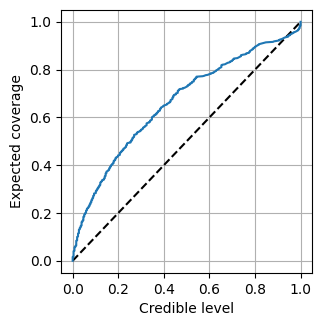

In [10]:
# TEST SET COVERAGE
testset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/testing_dataset_aux.h5')
print(len(testset))
n_max = 500

train_iterator = ((theta.cuda(), x[0].cuda().reshape(-1, 1, 52), x[2].cuda().reshape(-1, 52)) for theta, x in islice(testset, n_max))

levels, coverages = expected_coverage_mc(estimator.flow,
                                         train_iterator,
                                         n=256)

plt.close("all")
fig = coverage_plot(levels, coverages)
fig.savefig("/home/lwelzel/Documents/git/maldcope/test_coverage.png", dpi=400)

37280


150pair [00:22,  6.67pair/s]


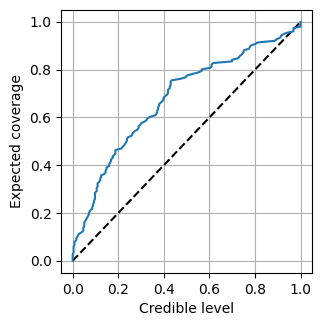

In [36]:
# TRAIN SET COVERAGE
trainset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/training_dataset_aux.h5')
print(len(trainset))
n_max = 150

train_iterator = ((theta.cuda(), x[0].cuda().reshape(-1, 1, 52), x[2].cuda().reshape(-1, 52)) for theta, x in islice(trainset, n_max))

levels, coverages = expected_coverage_mc(estimator.flow,
                                         train_iterator,
                                         n=256)

plt.close("all")
fig = coverage_plot(levels, coverages)
fig.savefig("/home/lwelzel/Documents/git/maldcope/train_coverage.png", dpi=400)

## Corner

DiagNormal(loc: torch.Size([7]), scale: torch.Size([7]))


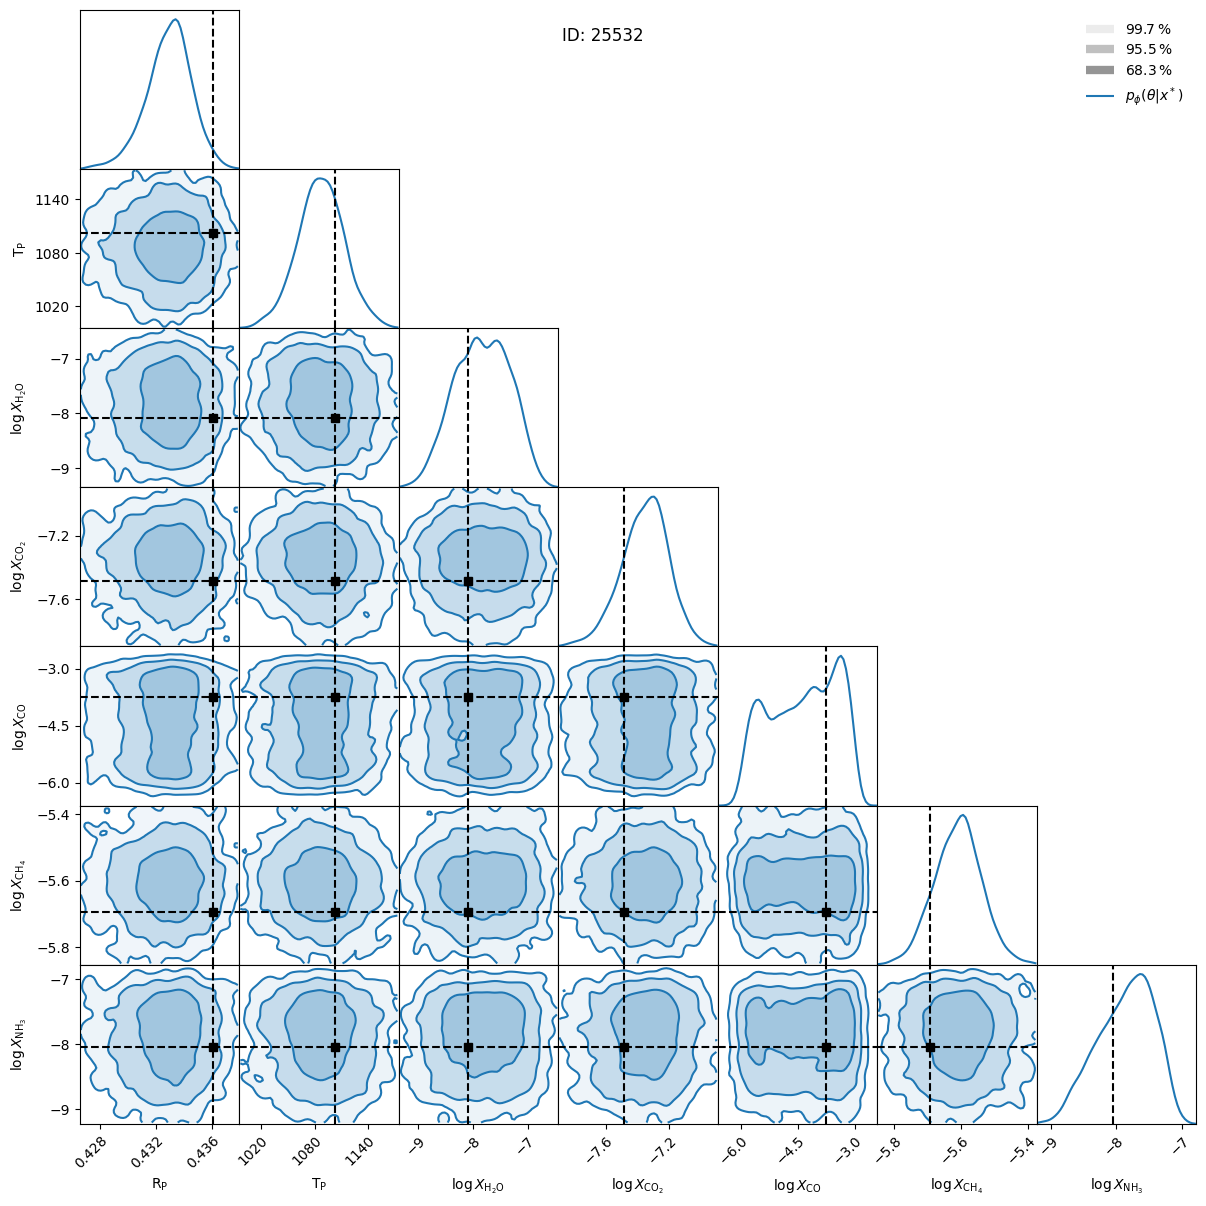

In [44]:
%matplotlib inline
trainset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/training_dataset_aux.h5')

sample_id = np.random.randint(0, 30000)


theta_star, x_star = trainset[sample_id]
theta_star, x_star = theta_star.cuda(), x_star.cuda()
x_star, x_prime_star = x_star[0].reshape((1, 1, -1)), x_star[2].reshape((1, -1))

# print(x_star, x_prime_star)
# print()

with torch.no_grad():
    theta = estimator.flow(x_star.cuda(), x_prime_star.cuda()).sample((2**12,)).cpu()
    # theta_0 = estimator.flow(x_star.cuda(), x_prime_star.cuda()).rsample((2**12,)).cpu()

theta = rescale_output(theta, forward=False).cpu()
# theta_0 = rescale_output(theta, forward=False).cpu()
theta_star = rescale_output(theta_star, forward=False).cpu()

LABELS, LOWER, UPPER = zip(*[
    [        r'${\rm R_{P}}$', -1e2,   1e2],  # planet_radius
    [        r'${\rm T_{P}}$', -1e2,   1e2],  # planet_temp
    [r'$\log X_{\rm H_{2}O}$', -1e2,   1e2],  # log_H2O
    [r'$\log X_{\rm CO_{2}}$', -1e2,   1e2],  # log_CO2
    [    r'$\log X_{\rm CO}$', -1e2,   1e2],  # log_CO
    [r'$\log X_{\rm CH_{4}}$', -1e2,   1e2],  # log_CH4
    [r'$\log X_{\rm NH_{3}}$', -1e2,   1e2],  # log_NH3
])



fig = corner(
    theta.reshape((-1, 7)),
    smooth=2,
    domain=None, # (LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    figsize=(12, 12),
)
fig.suptitle(f"ID: {sample_id}")
mark_point(fig, theta_star.cpu())
fig.savefig("/home/lwelzel/Documents/git/maldcope/random_corner.png", dpi=300)

# fig = corner(
#     theta_0.reshape((-1, 7)),
#     smooth=2,
#     domain=None, # (LOWER, UPPER),
#     labels=LABELS,
#     legend=r'$p_{\phi}(\theta | x^*)$',
#     figsize=(12, 12),
# )
# fig.suptitle(f"ID: {sample_id}")
# mark_point(fig, theta_star.cpu())

In [16]:
plt.close("all")

In [24]:
%matplotlib inline
testset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/testing_dataset_aux.h5')
theta_star, x_star = testset[260]
theta_star, x_star = theta_star.cuda(), x_star.cuda()
x_star, x_prime_star = x_star[0].reshape((1, 1, -1)), x_star[2].reshape((1, -1))

with torch.no_grad():
    theta = estimator.flow(x_star.cuda(), x_prime_star.cuda()).sample((2**12,)).cpu()

theta = rescale_output(theta, forward=False).cpu()
theta_star = rescale_output(theta_star, forward=False).cpu()

LABELS, LOWER, UPPER = zip(*[
    [        r'${\rm R_{P}}$', -1e2,   1e2],  # planet_radius
    [        r'${\rm T_{P}}$', -1e2,   1e2],  # planet_temp
    [r'$\log X_{\rm H_{2}O}$', -1e2,   1e2],  # log_H2O
    [r'$\log X_{\rm CO_{2}}$', -1e2,   1e2],  # log_CO2
    [    r'$\log X_{\rm CO}$', -1e2,   1e2],  # log_CO
    [r'$\log X_{\rm CH_{4}}$', -1e2,   1e2],  # log_CH4
    [r'$\log X_{\rm NH_{3}}$', -1e2,   1e2],  # log_NH3
])

fig = corner(
    theta.reshape(-1, 7),
    smooth=2,
    domain=None, # (LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    figsize=(12, 12),
)

mark_point(fig, theta_star.cpu())

NotImplementedError: Subclass DiagNormal of DiagNormal that defines a custom __init__ method must also define a custom .expand() method.

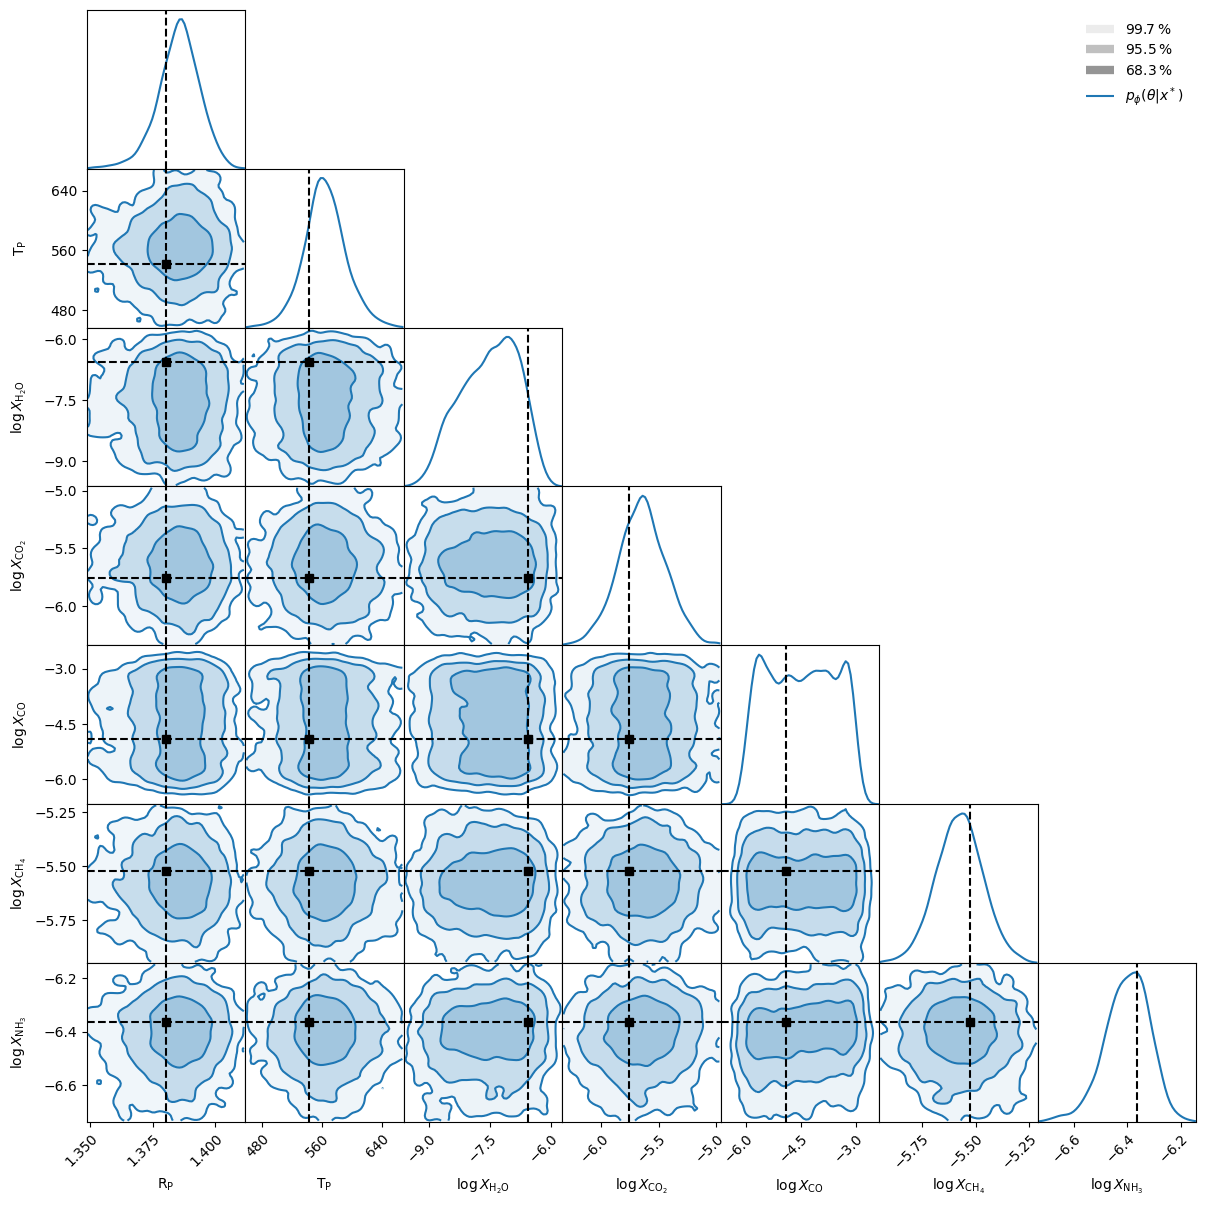

In [7]:
# MCMC comparison
%matplotlib inline
valid_set = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/valid_chain_dataset_aux.h5')
sample_id = np.random.randint(0, 6700)
theta_star, x_star = valid_set[sample_id]
theta_star, x_star = theta_star.cuda(), x_star.cuda()
x_star, x_prime_star = x_star[0].reshape((1, 1, -1)), x_star[2].reshape((1, -1))

with torch.no_grad():
    theta = estimator.flow(x_star.cuda(), x_prime_star.cuda()).sample((2**12,)).cpu()

theta = rescale_output(theta, forward=False).cpu()
theta_star = rescale_output(theta_star, forward=False).cpu()

LABELS, LOWER, UPPER = zip(*[
    [        r'${\rm R_{P}}$', -1e2,   1e2],  # planet_radius
    [        r'${\rm T_{P}}$', -1e2,   1e2],  # planet_temp
    [r'$\log X_{\rm H_{2}O}$', -1e2,   1e2],  # log_H2O
    [r'$\log X_{\rm CO_{2}}$', -1e2,   1e2],  # log_CO2
    [    r'$\log X_{\rm CO}$', -1e2,   1e2],  # log_CO
    [r'$\log X_{\rm CH_{4}}$', -1e2,   1e2],  # log_CH4
    [r'$\log X_{\rm NH_{3}}$', -1e2,   1e2],  # log_NH3
])

fig = corner(
    theta.reshape(-1, 7),
    smooth=2,
    domain=None, # (LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    figsize=(12, 12),
)

mark_point(fig, theta_star.cpu())

In [15]:
competition_output_path = Path("/home/lwelzel/Documents/git/maldcope/data/TrainingData/valid_chain_data.hdf5")
trace_data = h5py.File(competition_output_path)

trace_planet_list = [p for p in trace_data.keys()]
para_names = ['planet_radius', 'planet_temp', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']

print(trace_planet_list)
print(sample_id)
print(trace_planet_list[sample_id])

rtrace = trace_data[trace_planet_list[sample_id]]['tracedata'][()]

print(rtrace)
shape = rtrace.shape

if len(shape) > 0:
    valid = True

fig = corner(
    rtrace,
    labels=para_names
)

plt.show()

['Planet_train1', 'Planet_train10001', 'Planet_train10002', 'Planet_train10003', 'Planet_train10014', 'Planet_train1002', 'Planet_train10025', 'Planet_train10036', 'Planet_train10058', 'Planet_train10069', 'Planet_train10080', 'Planet_train10102', 'Planet_train10113', 'Planet_train10114', 'Planet_train10125', 'Planet_train10136', 'Planet_train10158', 'Planet_train10169', 'Planet_train10180', 'Planet_train10191', 'Planet_train10202', 'Planet_train10213', 'Planet_train10224', 'Planet_train10225', 'Planet_train10236', 'Planet_train10247', 'Planet_train10269', 'Planet_train10280', 'Planet_train10291', 'Planet_train10324', 'Planet_train10335', 'Planet_train10336', 'Planet_train10347', 'Planet_train10358', 'Planet_train10369', 'Planet_train10380', 'Planet_train10391', 'Planet_train10402', 'Planet_train10424', 'Planet_train10435', 'Planet_train10446', 'Planet_train10447', 'Planet_train10458', 'Planet_train10469', 'Planet_train10480', 'Planet_train10491', 'Planet_train10502', 'Planet_train1052

IndexError: invalid index to scalar variable.